In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [3]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", 
          "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", 
          "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5", "#c49c94"]
colors = colors+colors

In [156]:
dataset = 'purchase'
path = '../fl/'
params = {}
results = {}
models = {}
for r,d,f in os.walk(path):
    for file in f:
        if "params.json" in file:
            with open(r+'/'+file) as json_file:
                params[r] = json.load(json_file)
        elif "results.csv" in file:
            results[r] = pd.read_csv(r+'/'+file)
            it = []
            client = []
            model_filenames = []
            if 'Unnamed: 0' in results[r].keys():
                for k in results[r]['Unnamed: 0']:
                    it.append(k[k.find('i')+1:k.find('_')])
                    client.append(k[k.find('_')+1:k.find('.npy')])
                    model_filenames.append(k+'.npy')
                results[r]['it'] = it
                results[r]['client'] = client
                results[r]['file_name'] = model_filenames
                results[r].pop('Unnamed: 0')
        elif '.npy' in file:
            if r not in models:
                models[r] = {}
            models[r][file] = np.load(r+'/'+file)



In [161]:
fl_purchase = {}
for nodes in [2,4,8,16,32]:
    fl_purchase[nodes] = {}
    for dp in ['dpsgd','outdp']:
        res = prepare_for_plot(results, nodes, dp)
        fl_purchase[nodes][dp] = {}
        for file in res:
            fl_purchase[nodes][dp][file] = res[file]
#             res[file].to_csv(dataset+'/'+file[file.find('rs42_'):])


In [148]:
def prepare_for_plot(fl_results, nodes, dp_mode):

    outdp_list = []
    dp_sgd_list = []
    for i in fl_results:
        j = i+'_'
        if f'_ncl{nodes}_' in j and 'eps1_' in j and 'outDPlocalTrue' in j:
            outdp_list.append(i[:i.find('_eps')])
        elif f'_ncl{nodes}_' in j and 'eps1_' in j and 'sgdDPTrue' in j:
            dp_sgd_list.append(i[:i.find('_eps')])
    
    if dp_mode == 'outdp':
        sgd_or_out = outdp_list 
    elif dp_mode == 'dpsgd':
        sgd_or_out = dp_sgd_list
    else:
        return f'Wrong dp mode'
    
    if sgd_or_out == []:
        return f'No data found'
    
    results_to_plot = {}
    for i in sgd_or_out:
        collect_data = []
        for res in fl_results:
            if i in res:
                if params[res]['sgdDP']:
                    epsilon = params[res]['epsilon']
                elif params[res]['outDP_local']:
                    epsilon =  params[res]['outDP_local_epsilon']
    #             print(fl_results[res])
    #             print(params[res])
                for it in fl_results[res]['it'].unique():
                    row_client = {}
                    row_global = {}
                    it_data = fl_results[res].loc[fl_results[res]['it']==it]
                    clients_mean = it_data.loc[it_data['client']!='g'].drop(['file_name', 'it', 'client', 'attack_acc_std', 'attack_pre_std', 'attack_rec_std'], axis=1).mean()
                    clients_std = it_data.loc[it_data['client']!='g'].drop(['file_name', 'it', 'client', 'attack_acc_std', 'attack_pre_std', 'attack_rec_std'], axis=1).std()
                    attributes = list(clients_mean.keys()) + [i+'_std' for i in list(clients_mean.keys())]
                    values = list(clients_mean.values) + list(clients_std.values)
                    row_client['epsilon'] = row_global['epsilon'] = epsilon
                    row_client['iteration'] = row_global['iteration'] = it
                    row_client['client'] = 'c_mean'
                    row_global['client'] = 'g'
                    for at, val in zip(attributes,values):
                        row_client[at] = val
                    global_attr = it_data.loc[it_data['client']=='g'].drop(['file_name', 'it', 'client', 'attack_acc_std', 'attack_pre_std', 'attack_rec_std'], axis=1)
                    global_attr = global_attr.to_dict(orient='records')[0]
                    row_global.update(global_attr)
                    collect_data.append(row_client)
                    collect_data.append(row_global)
    #                 print(collect_data)
        collect_data_dict = {}
        for index,row in enumerate(collect_data):
            collect_data_dict[index] = row
        df = pd.DataFrame.from_dict(collect_data_dict, orient='index')
        results_to_plot[i] = df

    return results_to_plot

In [508]:
baseline = {}
for file in results:
    if '_sgdDPTrue' not in file and 'outDPlocalTrue' not in file:
        baseline[file] = {}
        for it in results[file]['it'].unique():
#             baseline[file][int(it)] = {}
#             baseline[file][int(it)]['clients_target'] = results[file].loc[results[file]['it']==it].loc[results[file]['client']!='g']['test_acc'].mean()
#             baseline[file][int(it)]['clients_attack'] = results[file].loc[results[file]['it']==it].loc[results[file]['client']!='g']['attack_acc_mean'].mean()
#             baseline[file][int(it)]['global_target'] = results[file].loc[results[file]['it']==it].loc[results[file]['client']=='g']['test_acc'].item()
#             baseline[file][int(it)]['global_attack'] = results[file].loc[results[file]['it']==it].loc[results[file]['client']=='g']['attack_acc_mean'].item()
            
            baseline[file][it] = {}
            baseline[file][it]['clients_target'] = results[file].loc[results[file]['it']==it].loc[results[file]['client']!='g']['test_acc'].mean()
            baseline[file][it]['clients_attack'] = results[file].loc[results[file]['it']==it].loc[results[file]['client']!='g']['attack_acc_mean'].mean()
            baseline[file][it]['global_target'] = results[file].loc[results[file]['it']==it].loc[results[file]['client']=='g']['test_acc'].item()
            baseline[file][it]['global_attack'] = results[file].loc[results[file]['it']==it].loc[results[file]['client']=='g']['attack_acc_mean'].item()


../fl/rs42_ncl32_fiter10_lr0.001_iter50_reg0.0001


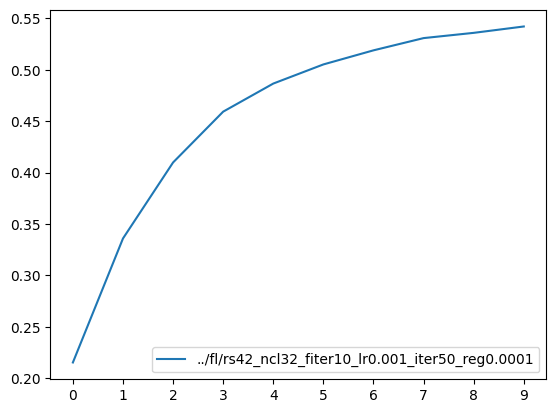

In [509]:

# ../fl/rs42_ncl2_fiter5_lr0.001_iter50_reg0.0001
for i in baseline:
    data = pd.DataFrame.from_dict(baseline[i], orient='index')
    if '_ncl32_' in i:# and '_lr0.01' in i and max(data['global_target'])>0.54:
        print(i)
        plt.plot(data['global_target'], label=i)
        plt.legend()

In [510]:
base_nodp = {}
base_nodp[2] = baseline['../fl/rs42_ncl2_fiter5_lr0.001_iter50_reg0.0001']
base_nodp[4] = baseline['../fl/rs42_ncl4_fiter10_lr0.001_iter50_reg0.0001']
base_nodp[8] = baseline['../fl/rs42_ncl8_fiter10_lr0.001_iter50_reg0.0001']
base_nodp[16] = baseline['../fl/rs42_ncl16_fiter10_lr0.001_iter50_reg0.0001']
base_nodp[32] = baseline['../fl/rs42_ncl32_fiter10_lr0.001_iter50_reg0.0001']

In [511]:
# fixed iterations

In [529]:
best_res = {}
best_res[(2,'sgd')] = '../fl/rs42_ncl2_fiter5_lr0.01_iter200_reg0.0001_sgdDPTrue'
best_res[(2,'out')] = '../fl/rs42_ncl2_fiter5_lr0.01_iter100_reg0.0001_outDPlocalTrue'

best_res[(4,'sgd')] = '../fl/rs42_ncl4_fiter5_lr0.01_iter100_reg0.0001_sgdDPTrue' #find better (regularization smaller?) / training phoibe 
best_res[(4,'out')] = '../fl/rs42_ncl4_fiter10_lr0.001_iter100_reg0.0001_outDPlocalTrue'

best_res[(8,'sgd')] = '../fl/rs42_ncl8_fiter5_lr0.01_iter100_reg0.0001_sgdDPTrue' #find better
best_res[(8,'out')] = '../fl/rs42_ncl8_fiter10_lr0.001_iter100_reg0.0001_outDPlocalTrue'

best_res[(16,'sgd')] = '../fl/rs42_ncl16_fiter5_lr0.01_iter100_reg0.0001_sgdDPTrue' #find better
best_res[(16,'out')] = '../fl/rs42_ncl16_fiter10_lr0.001_iter100_reg0.0001_outDPlocalTrue'

best_res[(32,'sgd')] = '../fl/rs42_ncl32_fiter10_lr0.01_iter100_reg0.0001_sgdDPTrue' #get closer to the baseline
best_res[(32,'out')] = '../fl/rs42_ncl32_fiter10_lr0.001_iter100_reg0.0001_outDPlocalTrue' #running phoibe lr0.01 check

../fl/rs42_ncl2_fiter5_lr0.001_iter100_reg0.0001_outDPlocalTrue
../fl/rs42_ncl2_fiter5_lr0.01_iter100_reg0.0001_outDPlocalTrue


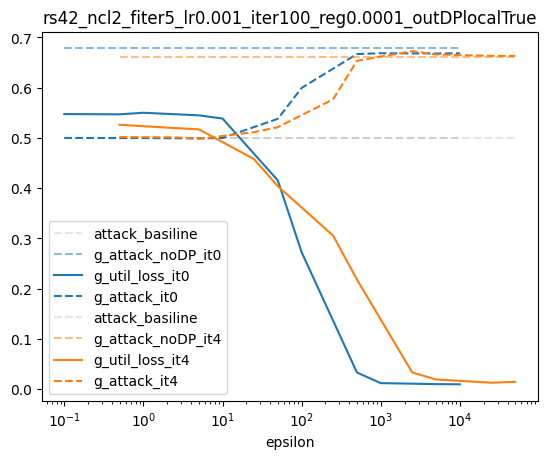

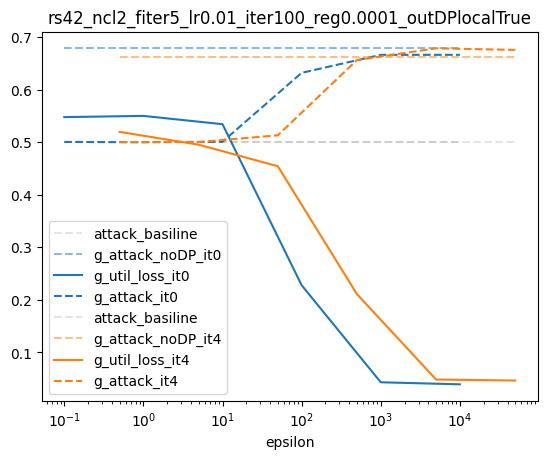

In [553]:
node = 2
data = {}
for i in fl_purchase[node]:
    for file in fl_purchase[node][i]:
        data[file] = fl_purchase[node][i][file]

for file in data:
#     print(file)
    if 'sgdDPTrue' in file or 'iter100' not in file:
        continue
    print(file)
    plt.figure()
    k=0
    for it in [data[file]['iteration'].unique()[0], data[file]['iteration'].unique()[-1]]:
        
        to_plot = data[file].loc[data[file]['iteration'] == it].sort_values(by=['epsilon'], ascending=True)
        to_plot['epsilon_updated'] = to_plot['epsilon']*(int(it)+1)
        
        g_node = to_plot.loc[to_plot['client']=='g'].loc[to_plot['epsilon']<=10000]
        c_node = to_plot.loc[to_plot['client']=='c_mean'].loc[to_plot['epsilon']<=10000]
        
        plt.plot([g_node['epsilon_updated'].iloc[0],g_node['epsilon_updated'].iloc[-1]], [0.5,0.5], '--', label='attack_basiline', color='0', alpha=0.1)
        plt.plot([g_node['epsilon_updated'].iloc[0], g_node['epsilon_updated'].iloc[-1]], [base_nodp[node][it]['global_attack'], base_nodp[node][it]['global_attack']], '--', label=f'g_attack_noDP_it{it}', color=colors[k], alpha=0.5)
        
        plt.plot(g_node['epsilon_updated'], base_nodp[node][it]['global_target'] - g_node['test_acc'], label=f'g_util_loss_it{it}', color=colors[k])
        plt.plot(g_node['epsilon_updated'], g_node['attack_acc_mean'], '--', label=f'g_attack_it{it}', color=colors[k])
        
#         plt.plot(c_node['epsilon_updated'], base_nodp[node][it]['clients_target'] - c_node['test_acc'], label='c_util_loss', color=colors[1])
#         plt.plot(c_node['epsilon_updated'], c_node['attack_acc_mean'] - base_nodp[node][it]['clients_attack'], '--', label='c_priv_loss', color=colors[1])
        plt.legend()
        plt.xscale('log')
        plt.xlabel('epsilon')
        f_name = file[file.find('rs42_'):]
        plt.title(f_name)
#         plt.savefig(f'purchase/best/{f_name}_fixed_iter_and_diff_epsilon.png')
        k+=1
#         print(c_node)
#         break
#     break

In [338]:
# fixed epsilon

/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_97280/291238561.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_node['int_iter'] = g_node['iteration'].astype('int64', copy=False)
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_97280/291238561.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_node['int_iter'] = g_node['iteration'].astype('int64', copy=False)
/var/folders/66/0p0lnj8d6zj532q0yvm1zt580000gn/T/ipykernel_97280/291238561.py:52: SettingWithCopyWarning: 
A value is 

<Figure size 640x480 with 0 Axes>

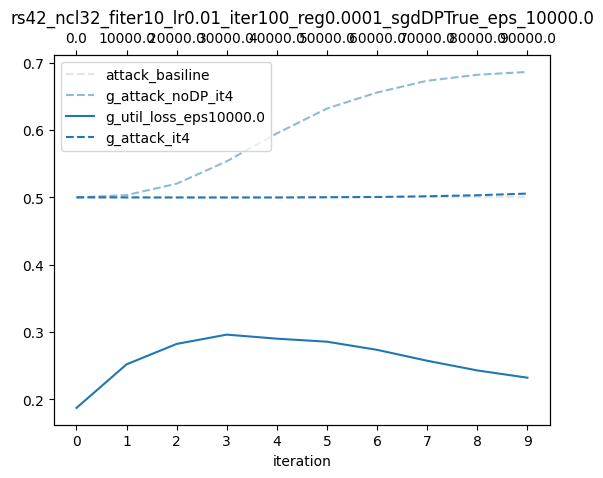

<Figure size 640x480 with 0 Axes>

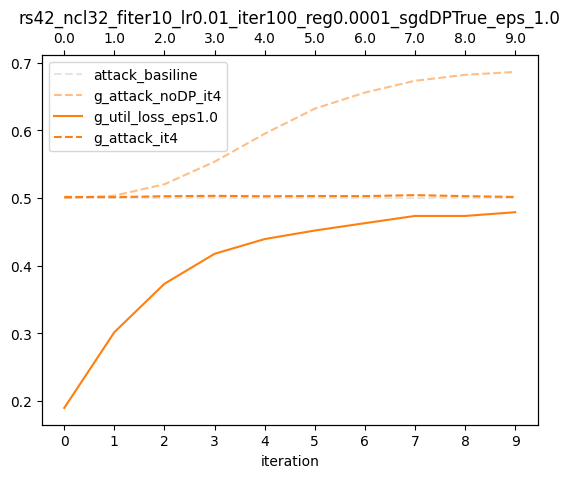

<Figure size 640x480 with 0 Axes>

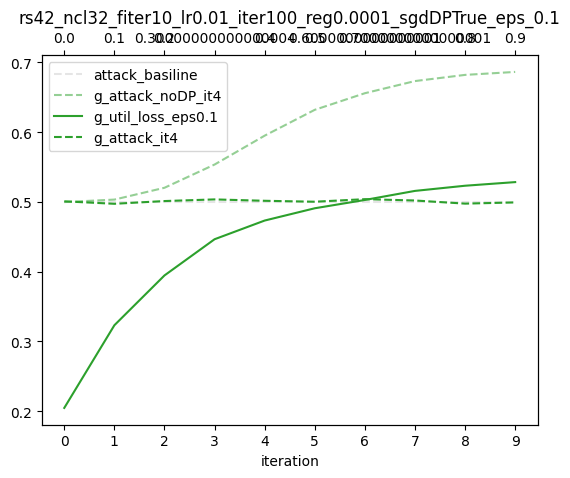

<Figure size 640x480 with 0 Axes>

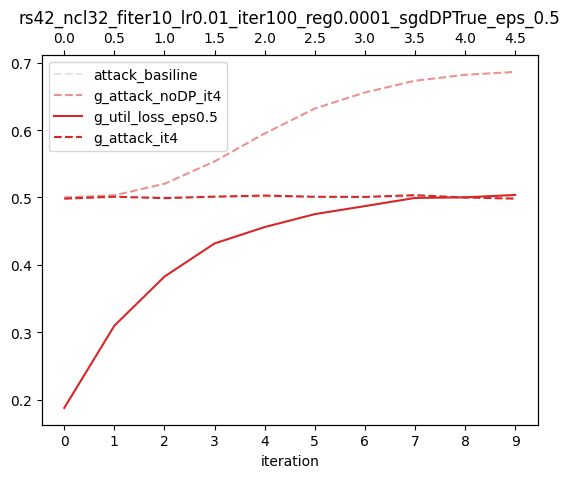

<Figure size 640x480 with 0 Axes>

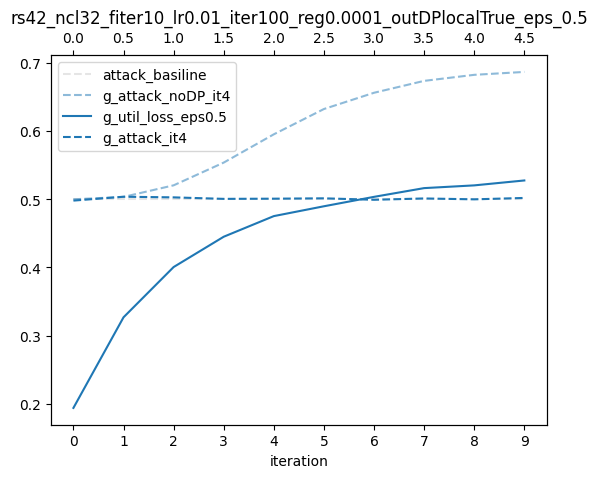

<Figure size 640x480 with 0 Axes>

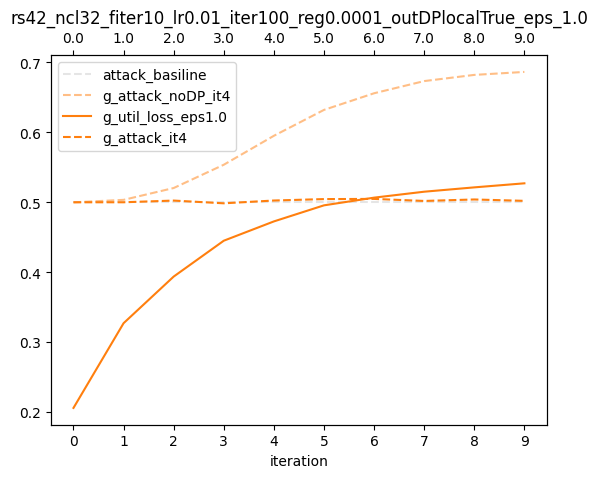

<Figure size 640x480 with 0 Axes>

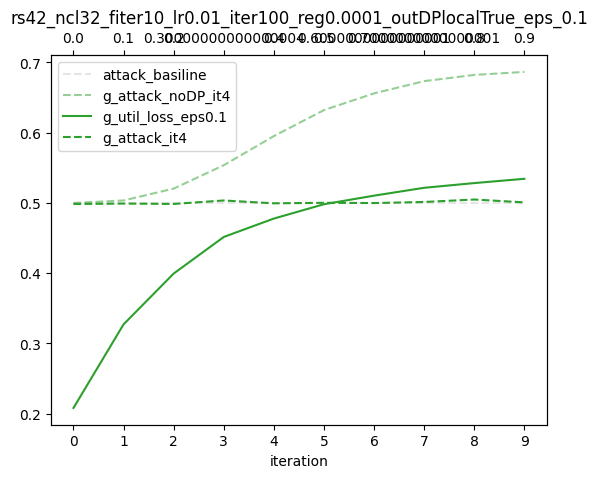

<Figure size 640x480 with 0 Axes>

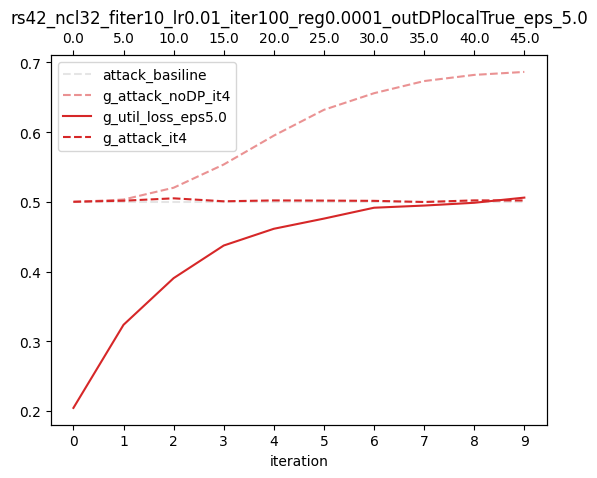

<Figure size 640x480 with 0 Axes>

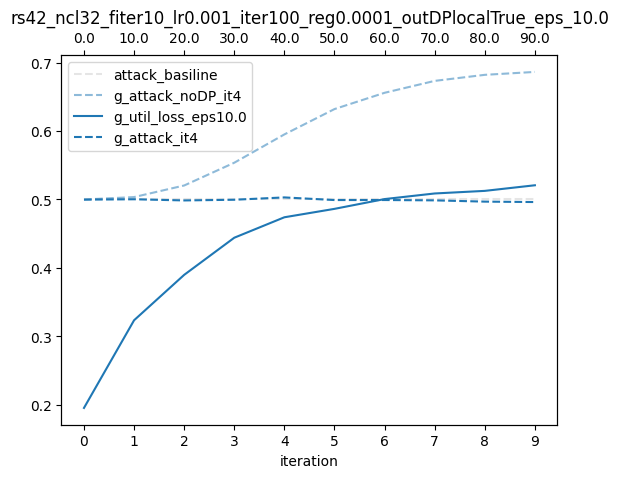

<Figure size 640x480 with 0 Axes>

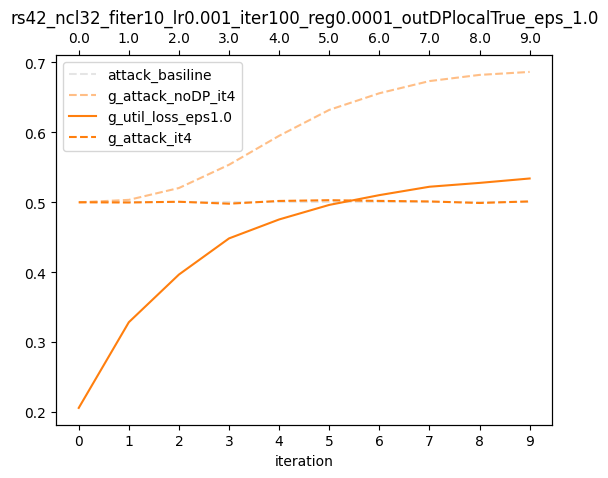

<Figure size 640x480 with 0 Axes>

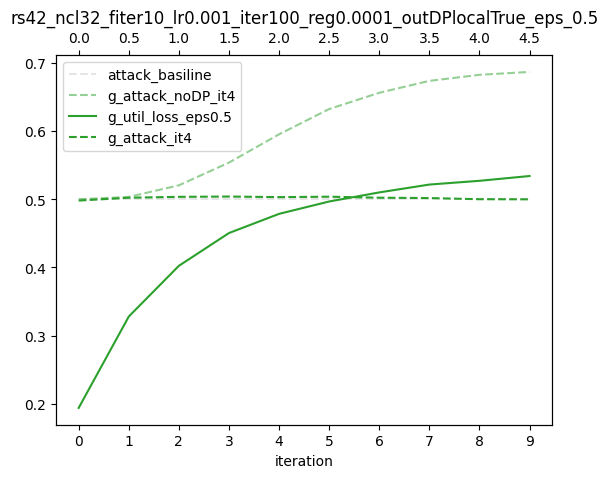

<Figure size 640x480 with 0 Axes>

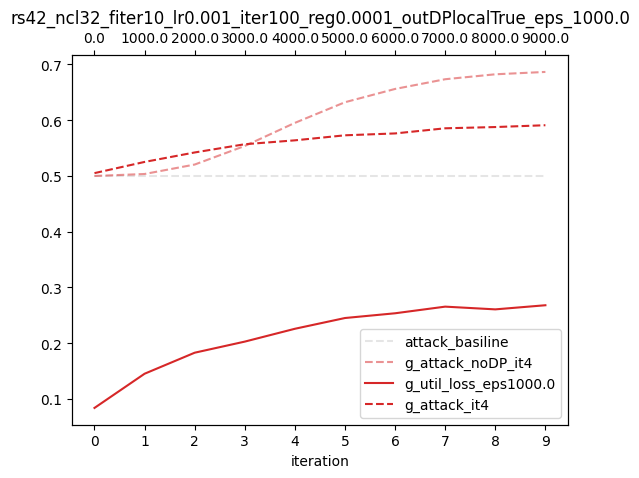

<Figure size 640x480 with 0 Axes>

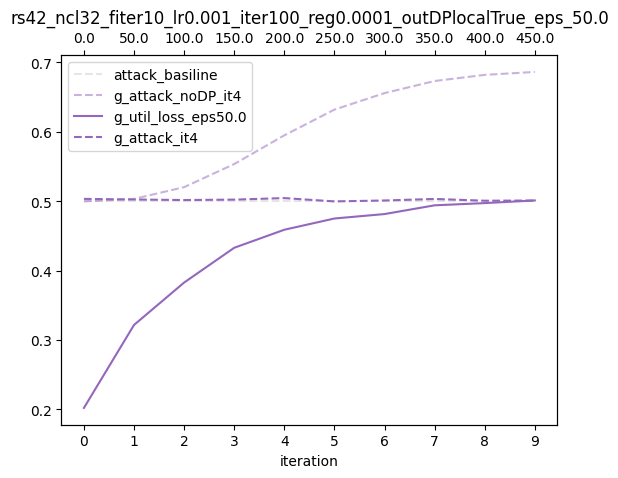

<Figure size 640x480 with 0 Axes>

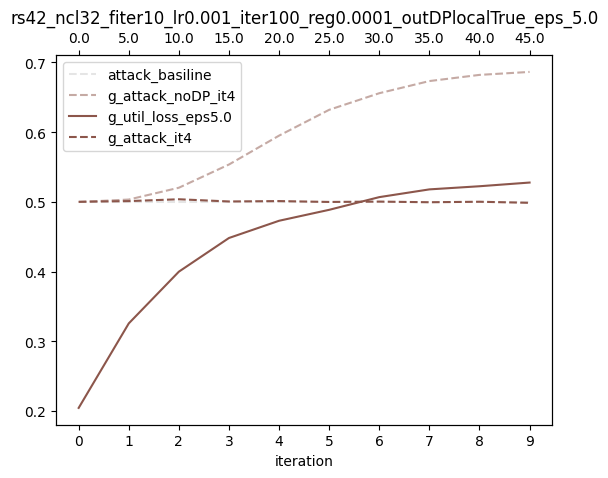

<Figure size 640x480 with 0 Axes>

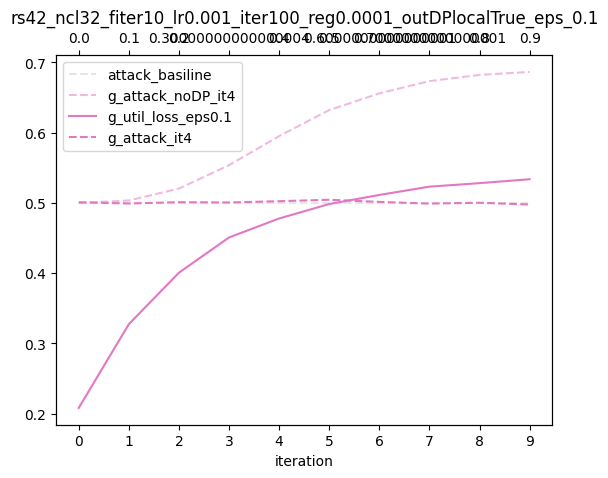

<Figure size 640x480 with 0 Axes>

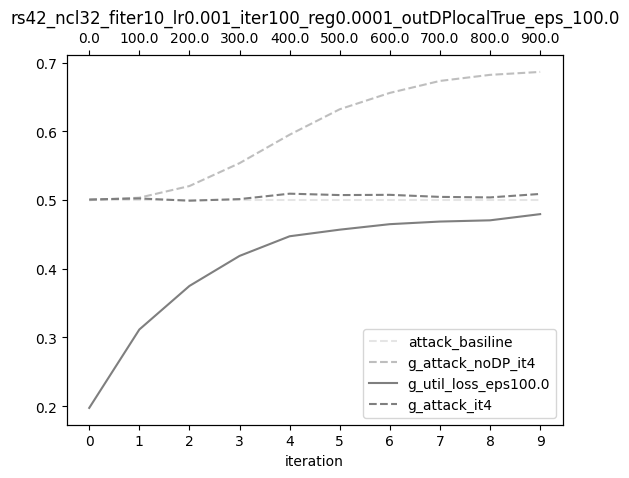

<Figure size 640x480 with 0 Axes>

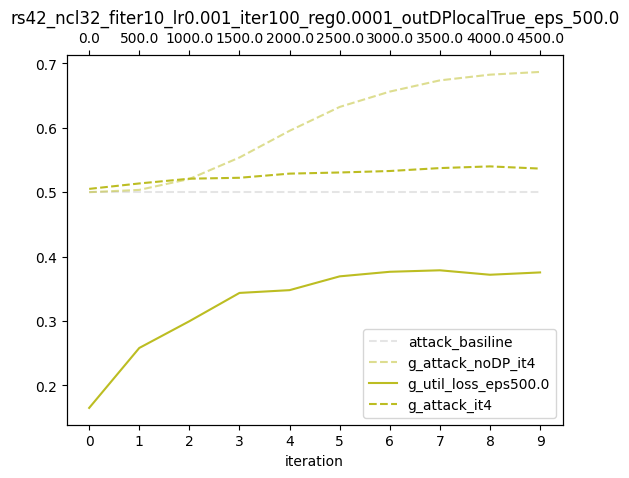

In [549]:
node = 32
data = {}
for i in fl_purchase[node]:
    for file in fl_purchase[node][i]:
        data[file] = fl_purchase[node][i][file]
        
for file in data:
    k=0
    for eps in data[file]['epsilon'].unique():
        plt.figure()
        
        to_plot = data[file].loc[data[file]['epsilon']==eps].sort_values(by=['iteration'], ascending=True)
        to_plot['epsilon_updated'] = to_plot['epsilon']*(int(it)+1)

        g_node = to_plot.loc[data[file]['client']=='g']
        c_node = to_plot.loc[data[file]['client']=='c_mean']
        
        base_util = [base_nodp[node][i]['global_target'] for i in base_nodp[node]]
        if len(base_util)==g_node['test_acc'].shape[0]:
#             print(1)
            global_util_loss = base_util - g_node['test_acc']
            base_attack = [base_nodp[node][i]['global_attack'] for i in base_nodp[node]]
        elif len(base_util)<g_node['test_acc'].shape[0]:
#             print(2)
            add_iter = g_node['test_acc'].shape[0] - len(base_util)
            new_base = base_util + [base_util[-1] for i in range(add_iter)]
            ba = [base_nodp[node][i]['global_attack'] for i in base_nodp[node]]
            base_attack = ba + [ba[-1] for i in range(add_iter)]
            global_util_loss = new_base - g_node['test_acc']
        elif len(base_util)>g_node['test_acc'].shape[0]:
#             print(3)
            len_iter = g_node['test_acc'].shape[0]
            global_util_loss = base_util[:len_iter] - g_node['test_acc']
            base_attack = [base_nodp[node][i]['global_attack'] for i in base_nodp[node]][:len_iter]
        
        fig, ax1 = plt.subplots()
        
        plt.plot([int(g_node['iteration'].iloc[0]),int(g_node['iteration'].iloc[-1])], [0.5,0.5], '--', label='attack_basiline', color='0', alpha=0.1)
        plt.plot(g_node['iteration'], base_attack, '--', label=f'g_attack_noDP_it{it}', color=colors[k], alpha=0.5)
        
        plt.plot(g_node['iteration'], global_util_loss, label=f'g_util_loss_eps{eps}', color=colors[k])
#         plt.plot(g_node['iteration'],  g_node['test_acc'], label=f'g_util_loss_eps{eps}', color=colors[k])
        plt.plot(g_node['iteration'], g_node['attack_acc_mean'], '--', label=f'g_attack_it{it}', color=colors[k])
        
        plt.legend()
        plt.xlabel('iteration')
        ax1.set_xticks([int(i) for i in g_node['iteration']])
        ax1.set_xticklabels(g_node['iteration'])
        ax2 = ax1.twiny()
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_xticks([int(i) for i in g_node['iteration']])
        g_node['int_iter'] = g_node['iteration'].astype('int64', copy=False)
        
        ax2.set_xticklabels(list(g_node['int_iter']*g_node['epsilon']))
        f_name = file[file.find('rs42_'):] + f'_eps_{eps}'
        plt.title(f_name)
        k+=1
#         print(g_node['iteration'])
        plt.savefig(f'{f_name}_fixed_epsilon_dif_iter.png')


In [483]:
base_util

[0.3614, 0.478, 0.5227, 0.5427, 0.5537, 0.558, 0.5615, 0.5627, 0.5621, 0.5629]